In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import random
import tqdm
import collections
import re
import json
import utils

In [2]:
random_seed = 1
random.seed(random_seed)

In [3]:
with open("data/name_to_smiles.json") as f:
    name_to_smiles = json.load(f)
smiles_to_name = {v:k for k,v in name_to_smiles.items()}
next(iter(name_to_smiles.items())), next(iter(smiles_to_name.items()))

(('amyl butyrate', 'CCCCCOC(=O)CCC'), ('CCCCCOC(=O)CCC', 'amyl butyrate'))

In [4]:
len(smiles_to_name)

2980

In [5]:
with open("../dataset/full.json") as f:
    full_data = json.load(f)
full_data[0]

{'mol1': 'CCCCC/C=C/C(=O)OC',
 'mol1_notes': ['violet',
  'sweet',
  'oily',
  'melon',
  'pear',
  'hairy',
  'costus',
  'fruity',
  'violet leaf',
  'waxy',
  'fresh',
  'green'],
 'mol2': 'CCCCCOC(=O)CCC',
 'mol2_notes': ['cherry',
  'sweet',
  'pineapple',
  'fruity',
  'banana',
  'tropical'],
 'blend_notes': ['animal', 'fruity', 'waxy']}

In [6]:
smiles_freq = collections.Counter()
for d in full_data:
    smiles_freq[d["mol1"]] += 1
    smiles_freq[d["mol2"]] += 1    
smiles_freq.most_common(1)

[('CC(CC1=CC2=C(C=C1)OCO2)C=O', 807)]

In [7]:
all_smiles, _ = list(zip(*smiles_freq.most_common()))
print(len(all_smiles))
all_smiles = [s for s in all_smiles if s in smiles_to_name]
len(all_smiles)

2971


2966

In [8]:
fraction = .01
smiles_sample = all_smiles[:int(fraction*len(all_smiles))]
len(smiles_sample)

29

In [9]:
edges = set()
for d in full_data:
    m1,m2 = d["mol1"],d["mol2"]
    if not m1 in smiles_sample or not m2 in smiles_sample:
        continue
    edges.add((m1,m2))
print(len(edges))
    
has_edge = set()
for s in smiles_sample:
    for (m1,m2) in edges:
        if s != m1 and s != m2:
            continue
        has_edge.add(s)
smiles_sample = list(has_edge)
len(smiles_sample)

361


29

In [10]:
import sklearn.model_selection
train, test = sklearn.model_selection.train_test_split(smiles_sample, test_size=0.2, random_state=random_seed)

In [11]:
G = nx.Graph()
for d in full_data:
    m1,m2 = d["mol1"],d["mol2"]
    if not m1 in smiles_sample or not m2 in smiles_sample:
        continue
    G.add_edge(m1,m2)

In [12]:
for s in train:
    assert s in smiles_to_name
for s in test:
    assert s in smiles_to_name

/var/folders/jv/6pqyzd1106l0jwdvbvjr5dn40000gn/T/ipykernel_18510/86097796.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos,style=edge_styles,edge_color=edge_colors,width=edge_weights)


23 train molecules and 6 test molecules.
Average degree = 12 and carving width = 113


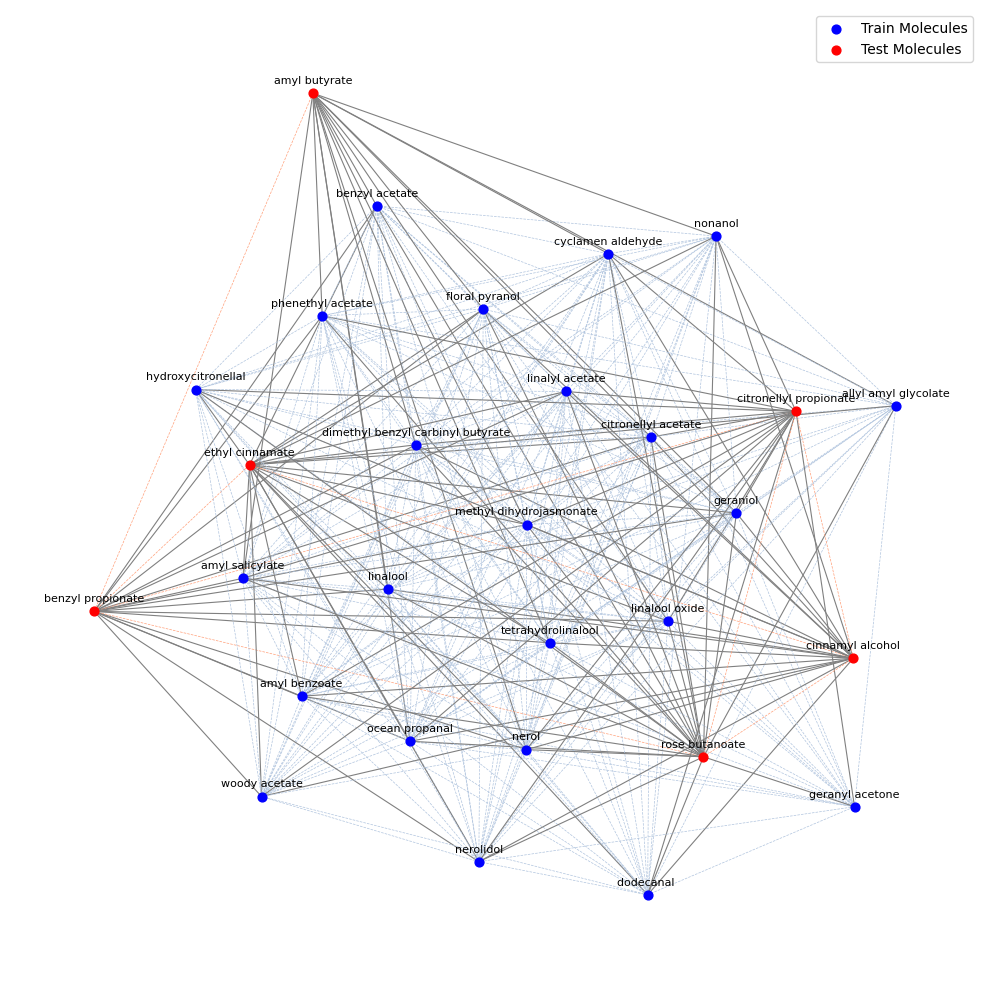

In [13]:
node_size = 40
train_color = "blue"
test_color = "red"

def get_edge_style(edge):
    m1,m2 = edge
    if m1 in train and m2 in train:
        return 'dashed', 'lightsteelblue', .5
    if m1 in test and m2 in test:
        return 'dashed', 'lightsalmon', .5
    return 'solid', 'grey', .8

def clean(name):
    # Remove parentheticals
    return re.sub(r"[\(\[].*?[\)\]]", "", name)

fig, ax = utils.standard_fig_ax()


pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=node_size, nodelist=train,
                       node_color=train_color, label='Train Molecules')
nx.draw_networkx_nodes(G, pos, node_size=node_size, nodelist=test,
                       node_color=test_color, label='Test Molecules')
edge_styles, edge_colors, edge_weights = list(zip(*[get_edge_style(edge) for edge in G.edges()]))
nx.draw_networkx_edges(G, pos,style=edge_styles,edge_color=edge_colors,width=edge_weights)

smiles_to_name = {k:clean(v) for k,v in smiles_to_name.items() if k in pos}
labels_pos = {k:[x,y+3e-2] for k,(x,y) in pos.items()}
nx.draw_networkx_labels(G, labels_pos,labels=smiles_to_name,font_size=8)

plt.legend()

plt.box(False)
carving_width = collections.Counter(edge_styles)["solid"]
print(f"{len(train)} train molecules and {len(test)} test molecules.")
print(f"Average degree = {int(G.number_of_edges()/G.number_of_nodes())} and carving width = {carving_width}")

plt.tight_layout()
utils.save_figures("carving",fig)
plt.show()